In [6]:
from collections import Counter
import sys
sys.path.append("/cluster/u/rrastogi/ECNN/X-CAP/src/utils")
from annovar_utils import get_transcripts_from_coding_changes
from evaluation_utils import *

from sklearn.metrics import auc, roc_curve

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

D_VALIDATION_TEST_VARIANTS = "/cluster/u/rrastogi/ECNN/results/d_validation/preprocess/remove_train/test.tsv"
D_VALIDATION_TEST_FEATURES = "/cluster/u/rrastogi/ECNN/results/d_validation/xcap/featurize_0520/total_test.features"

XCAP_MDL_FILE = "/cluster/u/rrastogi/ECNN/results/d_original/xcap/featurize_0520/clf.mdl"

In [2]:
clf = lgb.Booster(model_file=XCAP_MDL_FILE)

In [5]:
num_transcripts = []
for line in open(D_VALIDATION_TEST_VARIANTS):
    row = line.strip().split('\t')
    transcripts = get_transcripts_from_coding_changes(row[2])
    num_transcripts.append(len(transcripts))

In [27]:
labels, predictions = get_xcap_predictions(clf, D_VALIDATION_TEST_FEATURES)

In [61]:
bins = [
    [1, 1],
    [2, 5],
    [6, 39],
]

In [62]:
bin_data = []

for (start, end) in bins:
    indxs_in_bin = []
    for i, num_transcript in enumerate(num_transcripts):
        if start <= num_transcript <= end:
            indxs_in_bin.append(i)
    
    labels_subset = labels[indxs_in_bin]
    preds_subset = predictions[indxs_in_bin]
    bin_data.append((labels_subset, preds_subset))

In [63]:
bin_aurocs = []
bin_hsr_aurocs = []
for (labels_subset, preds_subset) in bin_data:
    fpr, tpr, _ = roc_curve(labels_subset, preds_subset)
    auroc = auc(fpr, tpr)
    hsr_auroc = getHsrAuc(fpr, tpr)
    bin_aurocs.append(auroc)
    bin_hsr_aurocs.append(hsr_auroc)

In [49]:
bin_aurocs

[0.9398755663851281, 0.9352832756799341, 0.9198235980055294]

In [64]:
bin_hsr_aurocs

[0.7110419921894073, 0.6900745253038609, 0.6324208734286296]

In [65]:
bin_labels = [
    "low: (1 - 1)",
    "mid: (2 - 5)",
    "high: (6 - 39)"
]

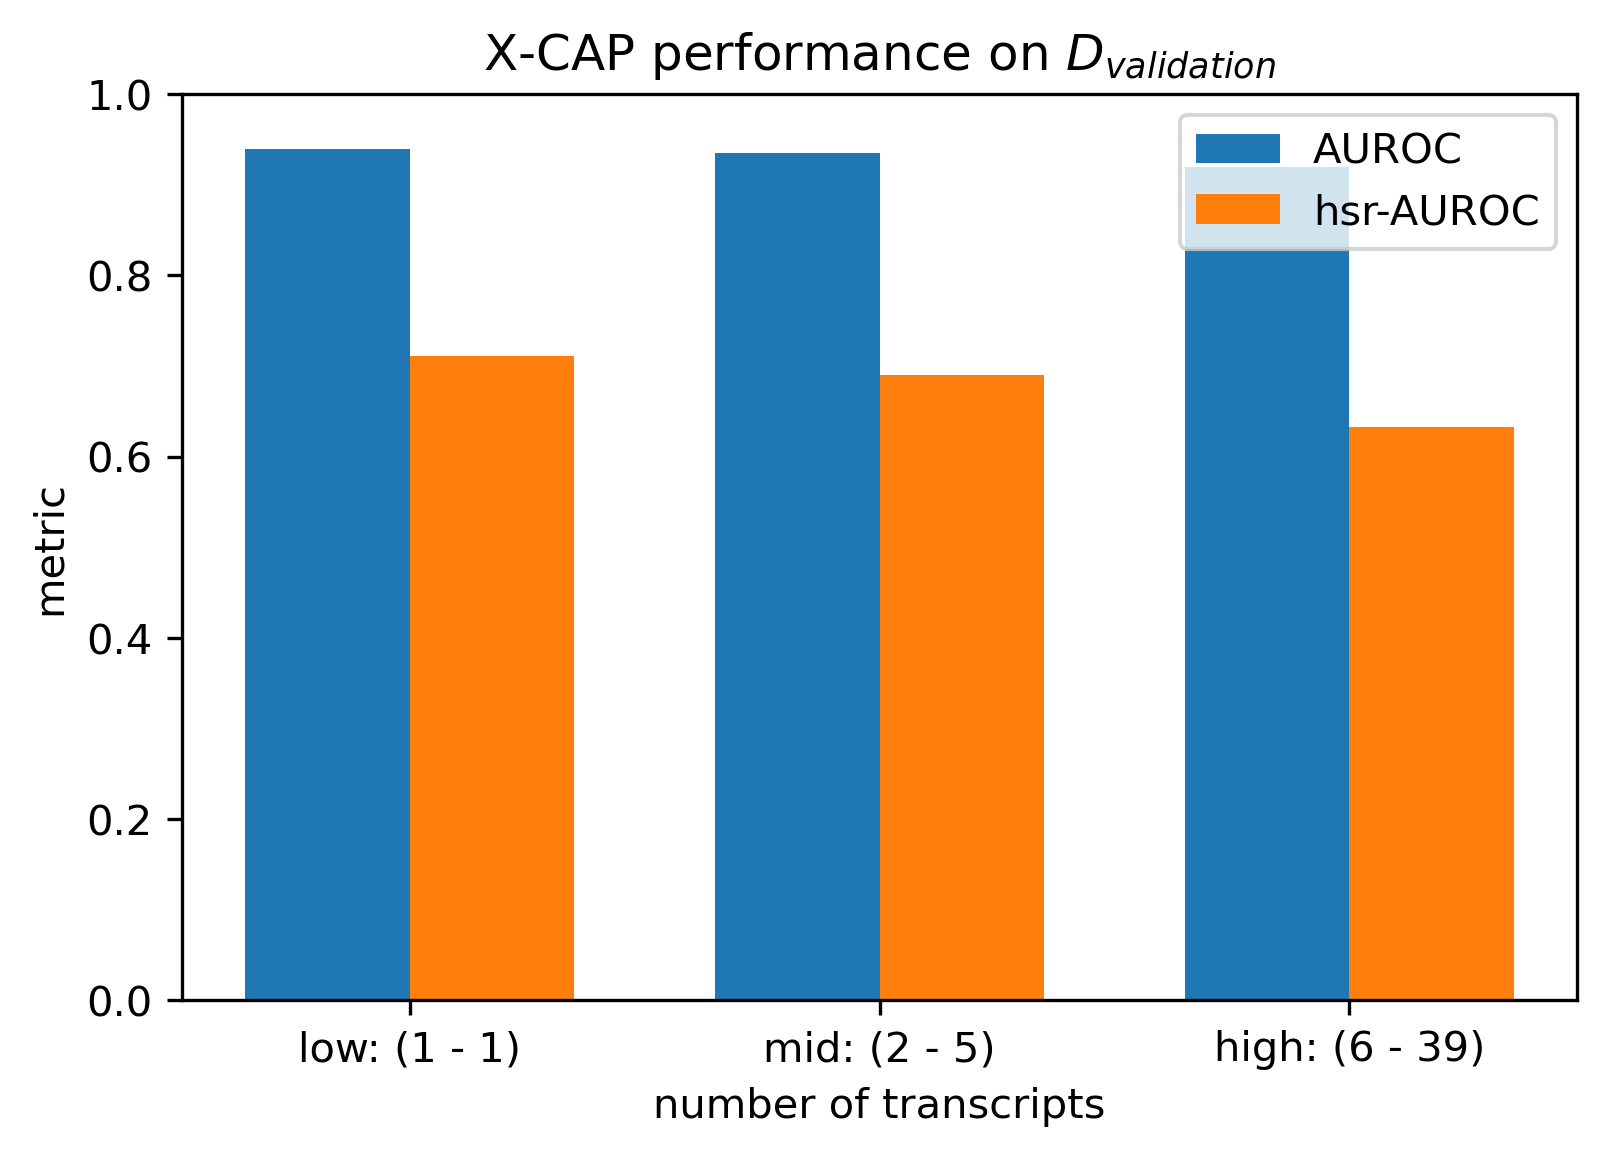

In [71]:
x = np.arange(len(bin_labels))
width = 0.35
plt.figure(dpi=300)
plt.bar(x - width / 2, bin_aurocs, width, label="AUROC")
plt.bar(x + width / 2, bin_hsr_aurocs, width, label="hsr-AUROC")
plt.title("")
plt.xlabel("number of transcripts")
plt.ylabel("metric")
plt.title("X-CAP performance on ${D}_{validation}$")
plt.xticks(x, bin_labels)
plt.ylim([0.0, 1.0])
plt.legend()
plt.show()